# 04-classification hw

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip 
!unzip bank.zip

--2025-10-20 13:05:26--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999,85K   815KB/s    in 1,2s    

2025-10-20 13:05:28 (815 KB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [5]:
df_all = pd.read_csv("bank-full.csv", sep=";")
df_all.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data preparation

In [6]:
df = df_all[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [24]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Split the data

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#### Q1 ROC AUC

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
df_train.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

In [26]:
y = df_train.y.values

for col in df_train.columns:
    check_type = df_train[col].dtype
    if check_type != 'object':
        score = roc_auc_score(y, df_train[col].values)
        if score < 0.5:
            score = roc_auc_score(y, -df_train[col].values)
            print(f"{col}: {score}")
        else:
            print(f"{col}: {score}")

age: 0.512185717527344
balance: 0.5888313805382317
day: 0.525957882383908
duration: 0.8147002759670778
campaign: 0.5714543015682159
pdays: 0.5901276247352144
previous: 0.5985653242764153


#### Q2: Training

In [55]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=10000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
y_train = df_train.y.values
y_val = df_val.y.values
del df_train['y']
del df_val['y']

In [33]:
dv, model = train(df_train, y_train, C=0.001)
y_pred = predict(df_val, dv, model)

/Users/garciada/Documents/GitHub/machine-learning-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
auc = roc_auc_score(y_val, y_pred)
auc

0.8770629378325877

#### Q3: Precision and recall

In [37]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 'yes')
    actual_negative = (y_val == 'no')
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [39]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,1098,7944,0,0,0.121433,1.000000
10,0.1,965,2241,133,5703,0.300998,0.878871
20,0.2,636,727,462,7217,0.466618,0.579235
30,0.3,426,350,672,7594,0.548969,0.387978
40,0.4,293,196,805,7748,0.599182,0.266849
50,0.5,198,119,900,7825,0.624606,0.180328
60,0.6,152,82,946,7862,0.649573,0.138434
70,0.7,103,64,995,7880,0.616766,0.093807
80,0.8,62,35,1036,7909,0.639175,0.056466
90,0.9,27,22,1071,7922,0.551020,0.024590


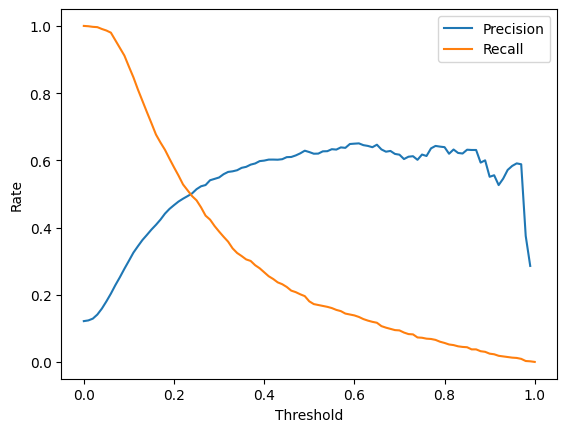

In [40]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()

In [41]:
df_scores['F1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.0,1098,7944,0,0,0.121433,1.000000,0.216568
10,0.1,965,2241,133,5703,0.300998,0.878871,0.448420
20,0.2,636,727,462,7217,0.466618,0.579235,0.516863
30,0.3,426,350,672,7594,0.548969,0.387978,0.454642
40,0.4,293,196,805,7748,0.599182,0.266849,0.369250
50,0.5,198,119,900,7825,0.624606,0.180328,0.279859
60,0.6,152,82,946,7862,0.649573,0.138434,0.228228
70,0.7,103,64,995,7880,0.616766,0.093807,0.162846
80,0.8,62,35,1036,7909,0.639175,0.056466,0.103766
90,0.9,27,22,1071,7922,0.551020,0.024590,0.047079


In [42]:
df_scores[df_scores.F1 == df_scores.F1.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1
19,0.19,664,794,434,7150,0.455418,0.604736,0.519562


#### Q5

In [60]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_index, val_index in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = df_train.y.values
        y_val = df_val.y.values

        del df_train['y']
        del df_val['y']
        
        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [61]:
print(np.mean(scores), np.std(scores))

0.9060038836791346 0.005598493850295184


#### Q6:

In [59]:
for C in [0.000001, 0.001, 1]:
    scores = []
    for train_index, val_index in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = df_train.y.values
        y_val = df_val.y.values
        del df_train['y']
        del df_val['y']
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%.6f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.000001 0.906 +- 0.006
C=0.001000 0.906 +- 0.006
C=1.000000 0.906 +- 0.006
